# Mass-conserving ice thickness dfNN (extention of the work)

Starting point: Currently we infer complete flux vectors from sparse flux vector observations. However, partial knowledge on the direction of the flux vector is - in some settings - available across the domain via satellite observations. Here, we explore how such partial obsertaions can be incorporated. We start by exploring how they can be incorporated into a hard-constrained dfNN. Additionally we may also want to leverage auxiliary variables like ice surface elevation to "lift" predictions of ice thickness. 

## Ideas, notes, terms
- dfGP: gradient observations
- differential constraint
- level sets

## Problem setting 

Let $\mathbf{v}(x_1, x_2)$ be a unit vector field and $t(x_1, x_2) \in \mathbb{R}$ a scalar field. Then the flux is defined as $\mathbf{q}(x_1, x_2) = \mathbf{v}(x_1, x_2) \cdot t(x_1, x_2)$, and we require that $\nabla \cdot \mathbf{q} = 0$.

Given:
- $\mathbf{v}(x_1, x_2) \in \mathbb{R}^2$ is given. This determines the direction of $\mathbf{q}(x_1, x_2)$.

Unknown:
- $t(x_1, x_2) \in \mathbb{R}$ is the variable we want to infer, ice thickness.

Output: 
- $\mathbf{q}(x_1, x_2) \in \mathbb{R}^2$ depth-integrated flux, subject to divergence-free constraint  

Relationship
- $\mathbf{v} * t = \mathbf{q}$   
with $\nabla \cdot \mathbf{q} = 0$

## Lemma 1: $\mathbf{v}$ determines direction of $\mathbf{q}$

The direction of $\mathbf{q}$ is equal to the direction of $\mathbf{v}$:
$
\frac{\mathbf{q}}{\|\mathbf{q}\|} = \frac{\mathbf{v}}{\|\mathbf{v}\|}
\quad \text{for all } (x_1, x_2). 
$

Therefore, $\mathbf{q}$ and $\mathbf{v}$ are **colinear** and point in the same direction at every point in the domain. $t$ essentially only scales the magnitude of the vector. 

## Lemma 2: $\mathbf{v}$ and $\mathbf{q}$ are orthogonal to the scalar potential $H$.

$
\mathbf{q}(x_1, x_2) = \nabla^\perp H(x_1, x_2) =
\begin{bmatrix}\phantom{-} \frac{\partial H}{\partial x_2} - \frac{\partial H}{\partial x_1}\end{bmatrix}.
$

$\mathbf{v}(x_1, x_2) \cdot \nabla H(x_1, x_2) = 0$ i.e. $\mathbf{v}(x_1, x_2) \perp \nabla H(x_1, x_2).$

Orthogonality between $\mathbf{v}(x)$ and $\nabla H(x)$ is preserved under nonzero scalar scaling of $\mathbf{v}$.


Then at each point $x$, the gradient $\nabla H(x)$ is constrained to lie in the subspace orthogonal to $\mathbf{v}(x)$:
$
\nabla H(x) \in \left\{ \mathbf{w} \in \mathbb{R}^2 \mid \mathbf{v}(x) \cdot \mathbf{w} = 0 \right\}.
$
This provides a linear constraint on the direction of $\nabla H(x)$ but does not determine its magnitude. Therefore, $\nabla H(x)$ is not uniquely determined by the orthogonality condition alone.

This is not a full gradient obsertaion but a orthogonality observation.

Conclusion: This make calculating a directionality loss at level H obvious. We might not actually want to hard-constrain it, but still remain flexibility of the model.

## Simple soft-constrained solution:
- Train the full dfNN on the direction onf of the output. (directional loss, conditioning phase)
- This is similar to training the PINN across the whole region, where we may want to interleave a step that constrains this.
- This might actually be useful if observations are noisy


"""def directional_loss(pred_vectors, target_directions, eps=1e-6):
    pred_directions = pred_vectors / (pred_vectors.norm(dim=-1, keepdim=True) + eps)
    cosine_similarity = (pred_directions * target_directions).sum(dim=-1)
    return ((1 - cosine_similarity)**2).mean()"""

Regular loss (e.g. MSE between predicted vector field and observed vector field)  
loss_data = F.mse_loss(pred_vector_field, observed_vector_field)

Directional constraint  
loss_direction = directional_loss(pred_vector_field, unit_directions)

Total loss  
loss = loss_data + lambda_dir * loss_direction

## Constrain H directly: Directional conditioning

### Questions:

If the true depth-averaged velocity is given by  
$
\mathbf{v}_{\text{depth}}(x) = c \cdot \mathbf{v}_{\text{surface}}(x), \quad \text{with } c \in (0.8, 1.0),
$  
then using $\mathbf{v}_{\text{surface}}$ in place of $\mathbf{v}_{\text{depth}}$ does not affect the inference of $t(x)$, since the equation $\nabla \cdot (\mathbf{v} \cdot t) = 0$ remains satisfied under constant scaling of $\mathbf{v}$. However, if $c = c(x)$ varies spatially, this rescaling introduces additional terms due to the product rule:
$
\nabla \cdot (t \cdot \mathbf{v}) = (\nabla \cdot \mathbf{v}) \cdot t + \mathbf{v} \cdot \nabla t,
$
and spatial variation in $c(x)$ affects both $\nabla \cdot \mathbf{v}$ and the coupling with $\nabla t$. Therefore, non-uniform velocity discounting has a direct impact on the inferred ice thickness distribution.

How do we incorporate these constraints into a dfGP?

In [2]:
from utils import make_grid
from simulate import simulate_convergence
from visualise import visualise_v_quiver
import matplotlib.pyplot as plt
import torch

In [3]:
_, x_grid = make_grid(n_side = 15)
# shift to avoid 0 value vectors
x_grid = x_grid + 0.1

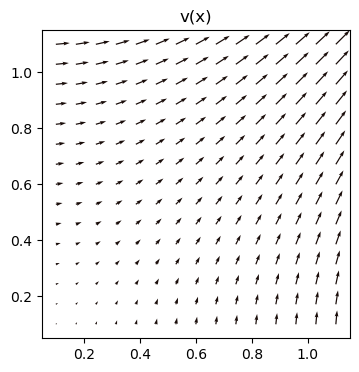

In [4]:
convergence = simulate_convergence(x_grid)
visualise_v_quiver(x_grid, convergence)

In [5]:
# compute magnitude (Euclidean norm) and devide by it to get unit vector
convergence_magnitude = torch.norm(convergence, dim = 1, keepdim = True)
convergence_unit = convergence / convergence_magnitude

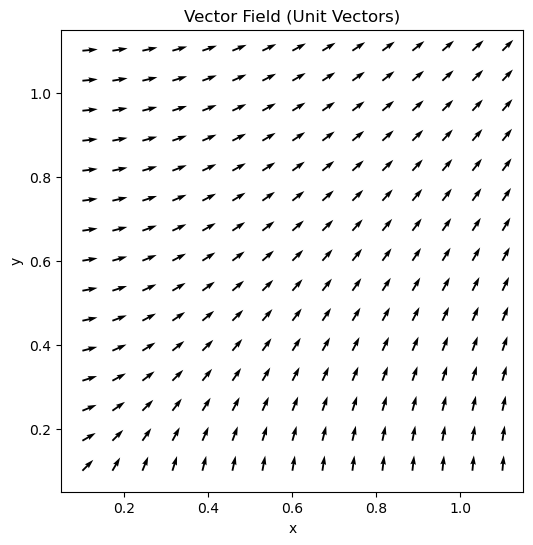

In [6]:
# Note how now all vectors have the same length but the direction still varies
import matplotlib.pyplot as plt
# Convert to NumPy if still torch tensors
x_np = x_grid.cpu().numpy()
v_np = convergence_unit.cpu().numpy()

# Split coordinates and vector components
x = x_np[:, 0]
y = x_np[:, 1]
u = v_np[:, 0]
v = v_np[:, 1]

# Plot
plt.figure(figsize = (6, 6))
plt.quiver(x, y, u, v, scale = 30)  # Adjust scale as needed
plt.gca().set_aspect('equal')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Vector Field (Unit Vectors)")
plt.show()

Now we have unit vectors and a scalar field. Let's make it a tiny bit more complex.

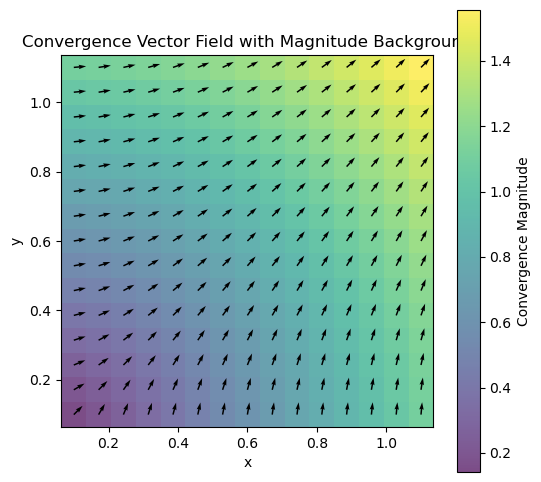

In [7]:
import matplotlib.pyplot as plt

# Assume:
# x_grid: [N, 2]
# convergence_unit: [N, 2]
# convergence_magnitude: [N]

# Infer H, W from the grid
N = x_grid.shape[0]
H = W = int(N**0.5)  # Assumes square grid — adjust if not square

# Extract components
x = x_grid[:, 0].reshape(H, W)
y = x_grid[:, 1].reshape(H, W)
u = convergence_unit[:, 0].reshape(H, W)
v = convergence_unit[:, 1].reshape(H, W)
mag = convergence_magnitude.reshape(H, W)

# Plot
plt.figure(figsize=(6, 6))

# 1. Background color (magnitude)
plt.pcolormesh(x, y, mag, shading = 'auto', cmap = 'viridis', alpha = 0.7)
plt.colorbar(label = "Convergence Magnitude")

# 2. Vector field on top
plt.quiver(x, y, u, v, scale = 30)

plt.gca().set_aspect('equal')
plt.title("Convergence Vector Field with Magnitude Background")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Now we are given v everywhere (for the direction) and we want to infer v

In [8]:
rescale = (0.8 + x_grid[:, 0] * 0.5).unsqueeze(-1)

convergence_v = convergence_unit * rescale
convergence_t = convergence_magnitude / rescale
q_from_vt = convergence_v * convergence_t

q_from_unitmag = convergence_unit * convergence_magnitude

torch.allclose(q_from_vt, q_from_unitmag, rtol = 1e-5, atol = 1e-8)

True

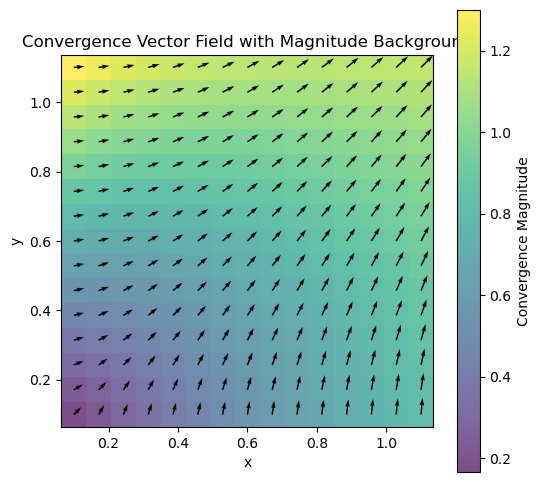

In [9]:
import matplotlib.pyplot as plt

# Assume:
# x_grid: [N, 2]
# convergence_unit: [N, 2]
# convergence_magnitude: [N]

# Infer H, W from the grid
N = x_grid.shape[0]
H = W = int(N**0.5)  # Assumes square grid — adjust if not square

# Extract components
x = x_grid[:, 0].reshape(H, W)
y = x_grid[:, 1].reshape(H, W)
u = convergence_v[:, 0].reshape(H, W)
v = convergence_v[:, 1].reshape(H, W)
mag = convergence_t.reshape(H, W)

# Plot
plt.figure(figsize=(6, 6))

# 1. Background color (magnitude)
plt.pcolormesh(x, y, mag, shading = 'auto', cmap = 'viridis', alpha = 0.7)
plt.colorbar(label = "Convergence Magnitude")

# 2. Vector field on top
plt.quiver(x, y, u, v, scale = 30)

plt.gca().set_aspect('equal')
plt.title("Convergence Vector Field with Magnitude Background")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Let's find the Hamiltonian potential:

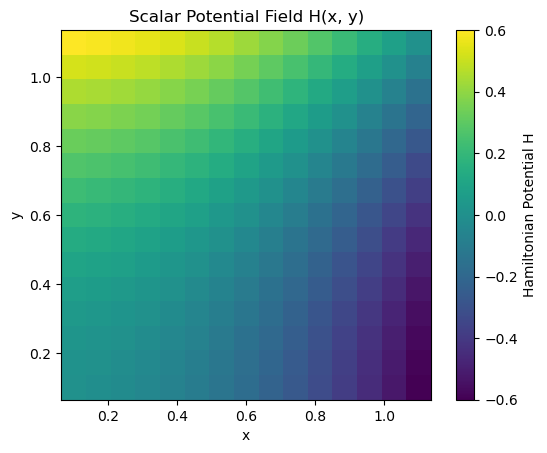

In [12]:
def compute_analytical_H_convergence(X):
    x = X[:, 0]
    y = X[:, 1]
    return 0.5 * y**2 - 0.5 * x**2  # Shape: [N]

H_analytical = compute_analytical_H_convergence(x_grid)
H_analytical_field = H_analytical.reshape(15, 15)

X = x_grid[:, 0].reshape(15, 15)
Y = x_grid[:, 1].reshape(15, 15)

plt.pcolormesh(X, Y, H_analytical_field, shading='auto', cmap='viridis')
plt.colorbar(label = "Hamiltonian Potential H")
plt.title("Scalar Potential Field H(x, y)")
plt.xlabel("x")
plt.ylabel("y")
plt.gca().set_aspect('equal')
plt.show()

In [13]:
def grad_H(X):
    x = X[:, 0]
    y = X[:, 1]
    grad = torch.stack([-x, y], dim=-1)  # ∇H
    return grad

grad_H_analytical = grad_H(x_grid)

In [ ]:
(grad_H_analytical * convergence_unit).sum(dim = 1, keepdim = True)
(grad_H_analytical * convergence).sum(dim = 1, keepdim = True)
# multiplied by any orthoganal it should be 0
(grad_H_analytical * convergence_v).sum(dim = 1, keepdim = True)

tensor([[ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 7.4506e-09],
        [ 7.4506e-09],
        [ 0.0000e+00],
        [ 7.4506e-09],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 7.4506e-09],
        [ 1.4901e-08],
        [ 7.4506e-09],
        [ 1.4901e-08],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 1.4901e-08],
        [-1.4901e-08],
        [-1.4901e-08],
        [ 0.0000e+00],
        [ 1.4901e-08],
        [ 0.0000e+00],
        [-1.4901e-08],
        [-1.4901e-08],
        [ 0.0000e+00],
        [-1.4901e-08],
        [-1.4901e-08],
        [-7.4506e-09],
        [ 7.4506e-09],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 1.4901e-08],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [-2.9802e-08],
        [ 2.9802e-08],
        [ 2.9802e-08],
        [ 0